## Notes / Hypotheses and ToDo's

- Different jobs have different sentiments
- Create Sentiment analysis of the title and check whether it matches the rating
- Obwohl wir eigentlich nur Deutsche Reviews verwenden, scheint doch einiges an Englischem Text drin zu sein. Vorher vielleicht nochmal eine Spracherkennung laufen lassen und Reviews analyisieren
- Zu stopwords auch BASF hinzufügen!

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
import dateparser
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
import torch
from textblob_de import TextBlobDE
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
from wordcloud import WordCloud

c:\users\dominik\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading

In [24]:
df = pd.read_csv('./data/dataset1_german_187.csv', delimiter=';')

df.drop(columns=['Column1'], inplace=True)
df.head()

,title,author_info,rating,pros,cons
0,Super,5. Mai 2023 - Chemikant und Anlagenfahrer,5,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",Ein riesiger laden etwas zu groß für mich
1,Verbesserungsvorschläge für eine noch bessere ...,20. Mai 2023 - Anlagenmechaniker,4,Globale Präsenz: BASF ist ein multinationaler ...,Größe und Komplexität: Als globaler Konzern mi...
2,"Gutes Gehalt, flexible Zeiten",23. Mai 2023 - Industriemechaniker,4,Das Einstiegsgehalt ist für einen Ausbildungsb...,Aufstiegsmöglichkeiten aufgrund der hohen Meng...
3,"Nettes Team, gute Erfahrung",16. Mai 2023 - Werkstudent,3,"Team, Einblicke, Support... Es hat Spaß gemach...",Die Organisation hat zeitweilig zu wünschen üb...
4,Führen durch Intransparenz,5. Mai 2023 - Ingenieur,2,Kündigungsschutz (betrieblich bedingt) von 5 J...,"Management, Führungskräfte und das gesamte Sys..."


In [25]:
df.shape

(187, 5)

In [26]:
# Create the 'plots' directory if it doesn't exist to save plots
if not os.path.exists('plots'):
    os.makedirs('plots')

## Data Cleaning

In [27]:
# Split the 'author_info' column into 'Date' and 'Job' columns
df[['date', 'job']] = df['author_info'].str.split('-', 1, expand=True)

In [28]:
# Convert the Date column to datetime format
df['date'] = df['date'].apply(lambda x: dateparser.parse(x, languages=['de']))

In [29]:
# Remove leading and trailing whitespaces from all columns
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [30]:
# Check for missing values and duplicates
print("Number of missing values:", df.isnull().sum().sum())
print("Number of duplicates:", df.duplicated().sum())

Number of missing values: 0
Number of duplicates: 0


In [31]:
# Ensure all text columns are of type string
text_cols = ['title', 'pros', 'cons', 'job']
for col in text_cols:
    df[col] = df[col].astype(str)

In [32]:
# Combine title, pros, cons into one column
df['text'] = df['title'] + ' ' + df['pros'] + ' ' + df['cons']

In [33]:
# Compute the length of reviews
df['review_length'] = df['text'].apply(len)
df['pros_length'] = df['pros'].apply(len)
df['cons_length'] = df['cons'].apply(len)

In [34]:
df.head()

,title,author_info,rating,pros,cons,date,job,text,review_length,pros_length,cons_length
0,Super,5. Mai 2023 - Chemikant und Anlagenfahrer,5,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",Ein riesiger laden etwas zu groß für mich,2023-05-05,Chemikant und Anlagenfahrer,"Super Gutes Gehalt, gute Arbeitszeit, gute Kol...",108,60,41
1,Verbesserungsvorschläge für eine noch bessere ...,20. Mai 2023 - Anlagenmechaniker,4,Globale Präsenz: BASF ist ein multinationaler ...,Größe und Komplexität: Als globaler Konzern mi...,2023-05-20,Anlagenmechaniker,Verbesserungsvorschläge für eine noch bessere ...,2742,1342,1328
2,"Gutes Gehalt, flexible Zeiten",23. Mai 2023 - Industriemechaniker,4,Das Einstiegsgehalt ist für einen Ausbildungsb...,Aufstiegsmöglichkeiten aufgrund der hohen Meng...,2023-05-23,Industriemechaniker,"Gutes Gehalt, flexible Zeiten Das Einstiegsgeh...",405,281,93
3,"Nettes Team, gute Erfahrung",16. Mai 2023 - Werkstudent,3,"Team, Einblicke, Support... Es hat Spaß gemach...",Die Organisation hat zeitweilig zu wünschen üb...,2023-05-16,Werkstudent,"Nettes Team, gute Erfahrung Team, Einblicke, S...",176,88,59
4,Führen durch Intransparenz,5. Mai 2023 - Ingenieur,2,Kündigungsschutz (betrieblich bedingt) von 5 J...,"Management, Führungskräfte und das gesamte Sys...",2023-05-05,Ingenieur,Führen durch Intransparenz Kündigungsschutz (b...,277,51,198


## Exploratory Data Analysis

In [35]:
print(f"Number of reviews: {len(df)}")

# Check the range of the rating column
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")

# Check the number of different jobs
print(f"Number of unique jobs: {df['job'].nunique()}")

# Check the time period of all reviews
print(f"Review time period: {df['date'].min().date()} - {df['date'].max().date()}")

Number of reviews: 187
Rating range: 1 - 5
Number of unique jobs: 126
Review time period: 2015-01-22 - 2023-05-23


#### Data Distributions

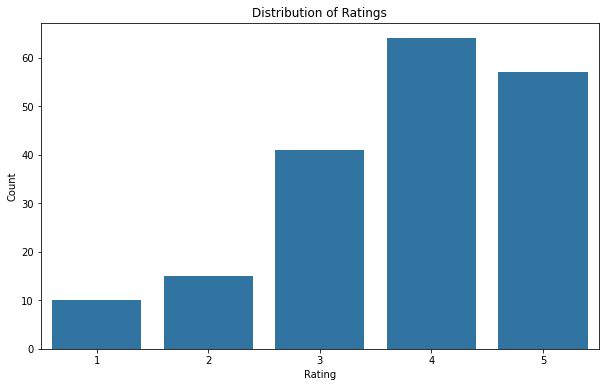

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, order=sorted(df['rating'].unique()), color=sns.color_palette()[0])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

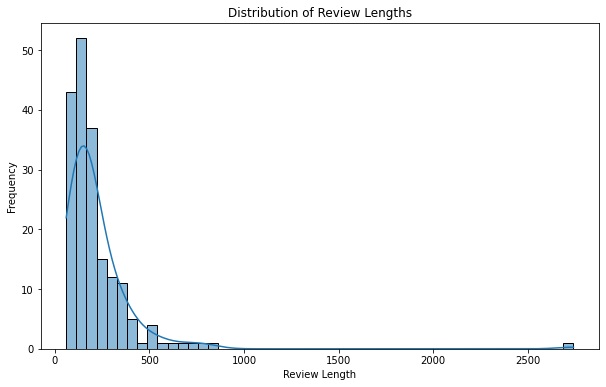

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

#### Remove Outliers

We can clearly see an outlier in the review length. Outliers can significantly affect the visualization and interpretation of the data. A common method to detect outliers is the IQR (interquartile range) method. In the IQR method, any value below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier, where Q1 and Q3 are the first and third quartiles, respectively, and IQR = Q3 - Q1.

In [38]:
# Calculate Q1, Q3, and IQR
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df[(df['review_length'] >= lower_bound) & (df['review_length'] <= upper_bound)]

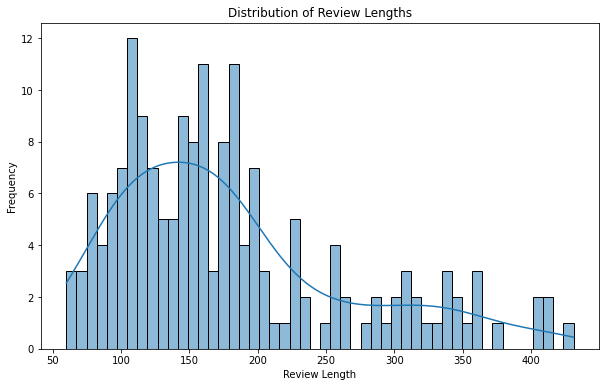

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

#### Development of Job Ratings over Time

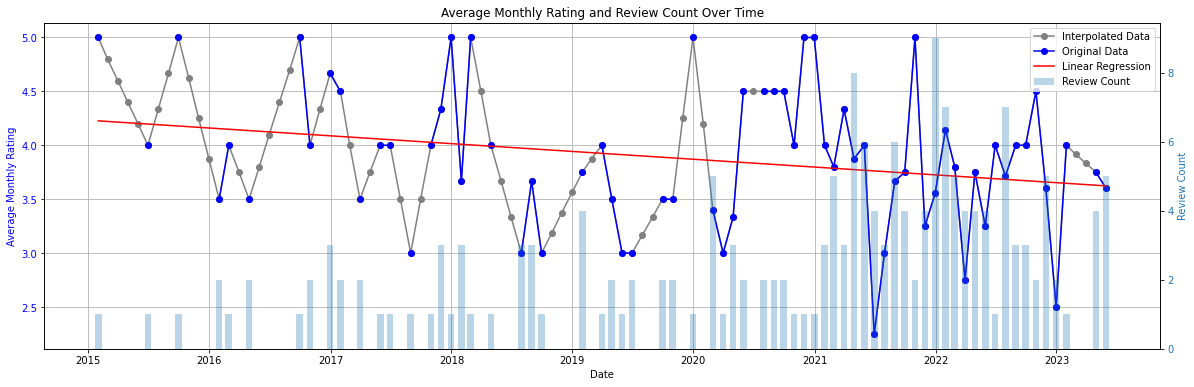

In [40]:
# Group by date (to the month) and calculate the average rating
average_ratings_monthly = df.groupby(pd.Grouper(key='date', freq='M'))['rating'].mean()

# Count the number of reviews per month
review_counts_monthly = df.groupby(pd.Grouper(key='date', freq='M')).size()

# Create a copy of original data before interpolation
average_ratings_monthly_before_interpolation = average_ratings_monthly.copy()

# Interpolate missing values
average_ratings_monthly.interpolate(method='linear', inplace=True)

# Define marker style and color for original and interpolated data
marker_style = dict(linestyle='-', marker='o', markersize=6)
original_marker_color = 'blue'
interpolated_marker_color = 'gray'

# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot the interpolated data
ax1.plot(average_ratings_monthly.index, average_ratings_monthly.values,
         color=interpolated_marker_color, 
         label='Interpolated Data',
         **marker_style)

# Overlay the original data
ax1.plot(average_ratings_monthly_before_interpolation.index, 
         average_ratings_monthly_before_interpolation.values,
         color=original_marker_color, 
         label='Original Data',
         **marker_style)

# Fit a Linear Regression model
X = mdates.date2num(average_ratings_monthly.index.to_pydatetime()).reshape(-1, 1)  # Convert dates to numerical format for regression
y = average_ratings_monthly.values
model = LinearRegression()
model.fit(X, y)

# Generate predicted ratings
y_pred = model.predict(X)

# Plot the regression line
ax1.plot(average_ratings_monthly.index, y_pred, color='red', label='Linear Regression') 

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Monthly Rating', color=original_marker_color)
ax1.tick_params(axis='y', labelcolor=original_marker_color)
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.bar(review_counts_monthly.index, review_counts_monthly.values, 
        width=20, align='center', color=sns.color_palette()[0], alpha=0.3, label='Review Count')
ax2.set_ylabel('Review Count', color=sns.color_palette()[0])
ax2.tick_params(axis='y', labelcolor=sns.color_palette()[0])

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title('Average Monthly Rating and Review Count Over Time')
plt.savefig('plots/monthly_rating_over_time.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


The red line in the plot shows the trend line from the linear regression, so we can see a slight negative trend of the review ratings. However, the result is not really reliable, as we only have few data.

#### People who write less are in general more satiesfied?

In [41]:
# Check the correlation between 'rating' and 'review_length'
correlation = df[['rating', 'review_length']].corr()

# Print the correlation between 'rating' and 'review_length'
print("Correlation between rating and review length:", correlation.loc['rating', 'review_length'])
print("Correlation between rating and review length (outlier removed):", df_filtered['rating'].corr(df_filtered['review_length']))

Correlation between rating and review length: -0.1051322109885755
Correlation between rating and review length (outlier removed): -0.1150341881048161


The correlation coefficient ranges from -1 to 1. A value closer to -1 indicates a strong negative correlation, a value closer to 1 indicates a strong positive correlation, and a value closer to 0 indicates no correlation.

However, correlation does not imply causation. Even if we find a strong correlation between review length and rating, it does not necessarily mean that writing shorter reviews causes higher job satisfaction, it just means that they are associated. There could be other underlying factors causing both to occur.

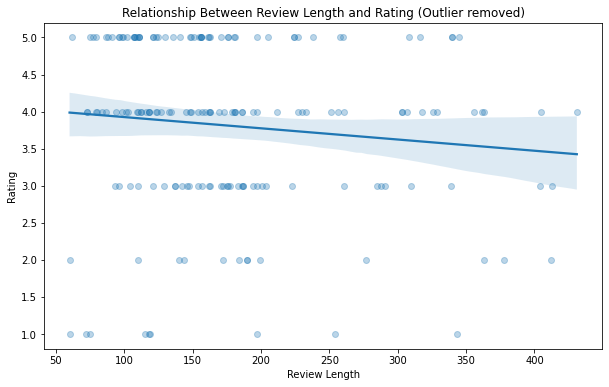

In [42]:
plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='rating', data=df_filtered, scatter_kws={'alpha':0.3})
plt.title('Relationship Between Review Length and Rating (Outlier removed)')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()

In this plot, each dot represents a review. The x-coordinate of the dot is the length of the review, and the y-coordinate is the rating. The line in the plot is the best fit linear regression line.

If your hypothesis is correct, we should expect to see a negative slope, suggesting that longer reviews tend to have lower ratings. The alpha parameter for the scatter plot is set to 0.3 for better visibility when data points overlap.

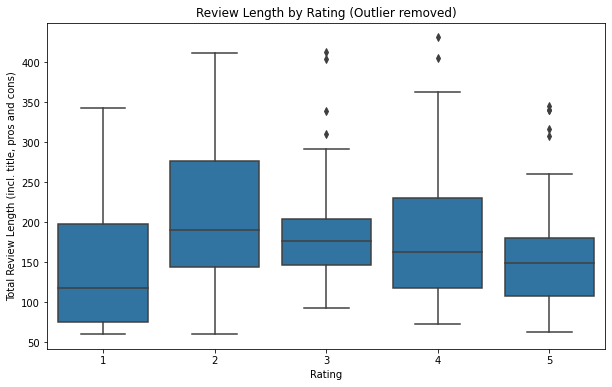

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='review_length', data=df_filtered, color=sns.color_palette()[0])
plt.title('Review Length by Rating (Outlier removed)')
plt.xlabel('Rating')
plt.ylabel('Total Review Length (incl. title, pros and cons)')
plt.show()

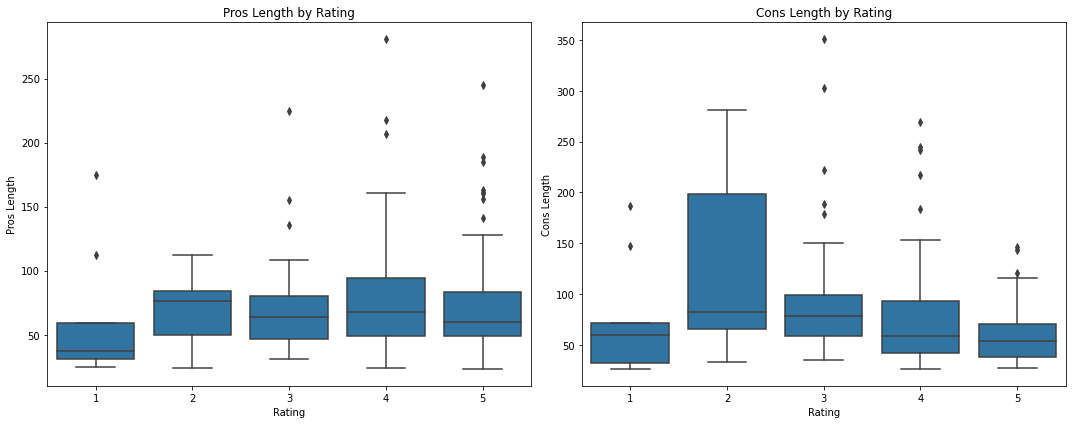

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='rating', y='pros_length', data=df_filtered, ax=ax[0], color=sns.color_palette()[0])
ax[0].set_title('Pros Length by Rating')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Pros Length')

sns.boxplot(x='rating', y='cons_length', data=df_filtered, ax=ax[1], color=sns.color_palette()[0])
ax[1].set_title('Cons Length by Rating')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Cons Length')

plt.tight_layout()
plt.show()

Here we can see that it looks like nearly all reviews have the same length independent of the rating. However, there is a slight tendency that negativ reviews with the rating of 1 have less text and reviews with a rating of 2 have more text.

If we have a look at the specific length of the positive text, we can see that people tend to write less positive text if they rated the company with 1.

For the negative text, we can see that people generally write and slightly less if the review was positive, but they tend to write especially much negative text when they rated the company with a 2.

## TF-IDF and Word Clouds
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

**TF (Term Frequency)** is the number of times a word appears in a document, divided by the total number of words in that document.  
**IDF (Inverse Document Frequency)** is the log of the number of documents divided by the number of documents that contain the word. In other words, it reduces the weight of words that occur very often in the dataset and increases the weight of words that occur rarely.

Note: It is also important to mention, that one should first remove the stop words, because those words will else distort the analysis and less meaningful words will appear in the word cloud, that would be usually filtered out by the stopword list.

In [4]:
nltk.download('stopwords')
german_stop_words = set(stopwords.words('german'))
# add 'BASF' to the stopwords
german_stop_words.add('BASF')
german_stop_words.add('Basf')
german_stop_words.add('basf')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Function to calculate TF-IDF and generate word cloud
def generate_word_cloud_and_top_tfidf(df, column, top_n=10):
    # Define the TF-IDF vectorizer that will be used to process the data
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words=german_stop_words)

    # Apply this vectorizer to the column of the dataset
    features = tfidf.fit_transform(df[column].values.astype('U'))

    # Get the names of the features
    feature_names = tfidf.get_feature_names_out()

    # Get the scores of each feature in each review
    scores = features.toarray()

    # Initialize dictionaries to store the total scores for each word
    total_scores = {word: 0 for word in feature_names}

    # Add up the scores for each word
    for i in range(len(feature_names)):
        total_scores[feature_names[i]] += sum(scores[:, i])

    # Sort the total scores dictionary by score and get the top N terms
    sorted_scores = sorted(total_scores.items(), key=lambda x: x[1], reverse=True)
    top_terms = sorted_scores[:top_n]

    # Print the top N terms and their scores
    print(f"Top {top_n} terms in {column} column and their TF-IDF scores:")
    for term, score in top_terms:
        print(f"{term}: {score}")

    # Initialize a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color ='white')

    # Generate the word cloud
    wordcloud.generate_from_frequencies(total_scores)

    # Display the generated image:
    plt.figure(figsize=(10, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

Top 10 terms in pros column and their TF-IDF scores:
kollegen: 17.721900885846786
gute: 17.195414973328262
gehalt: 13.03818678747382
gut: 12.089857863427504
aufgaben: 9.86214156279901
nette: 9.448406072011343
gutes: 8.866673311694283
mitarbeiter: 8.662251552389334
unternehmen: 8.413309148088182
viele: 8.087057989304657


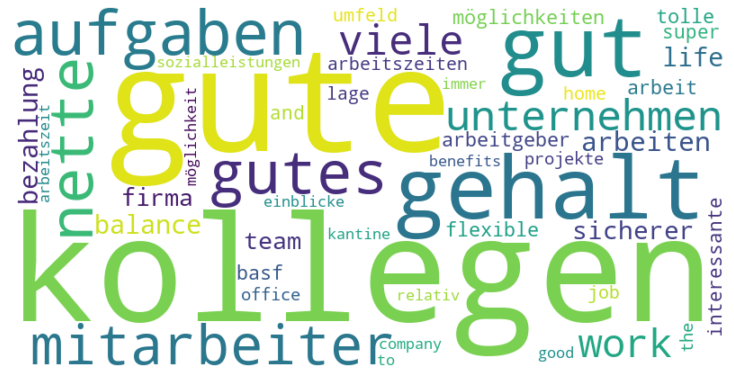

In [47]:
# Generate word clouds and print top TF-IDF terms for 'pros' column
generate_word_cloud_and_top_tfidf(df, 'pros')

Top 10 terms in cons column and their TF-IDF scores:
gehalt: 12.685248435260842
wenig: 11.278900344536703
mitarbeiter: 10.875242064788049
viele: 8.453982159017553
unternehmen: 7.442145822592124
manchmal: 7.043495069399436
mehr: 6.332862877700026
basf: 4.949044631877342
entwicklung: 4.889578617090809
träge: 4.688405348438581


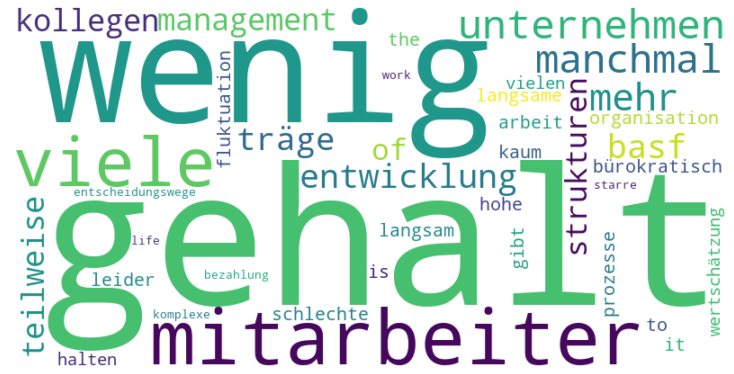

In [48]:
# Generate word clouds and print top TF-IDF terms for 'cons' column
generate_word_cloud_and_top_tfidf(df, 'cons')

#### Problem with Unigrams and the Need for Context
In natural language processing (NLP), a significant challenge is the ability to capture the context and semantic relationships between words in a text document. Unigrams, or single words, are often used in text analysis, as in the case of bag-of-words models or in TF-IDF (Term Frequency-Inverse Document Frequency) approaches. While unigrams can give a good indication of the most significant words in a document, they fail to capture the context in which these words are used.

For example, consider analyzing employee reviews of a company. Words like "less", "slow", or "small" might frequently appear in negative reviews. However, without context, it's hard to understand what exactly these reviews are referring to. Is the company slow to implement projects? Is there less payment than expected? Is the company in general too small? Unigrams do not provide this level of detail.

#### Approach Using Bigrams
One approach to capture more context in text data is to use n-grams, which are continuous sequences of 'n' words from the text. Bigrams (n=2) are sequences of two consecutive words, and trigrams (n=3) are sequences of three consecutive words.

Using bigrams instead of or in addition to unigrams can help to capture relationships between consecutive words and provide more context. For example, in the case of our job reviews, instead of the unigram "less", we could have the bigram "less salary". These bigrams offer more insight into the specific complaints of the customers.

However, it's important to note that while bigrams and higher order n-grams can provide more context, they also significantly increase the dimensionality of the data, which can make models more complex and computationally expensive. Furthermore, they might not always provide additional value, depending on the specific task and data. Therefore, it's crucial to use them judiciously, considering the trade-off between capturing more context and maintaining manageable model complexity.

In our case, we used the TfidfVectorizer with the parameter ngram_range=(2, 2), which considers only bigrams. This approach allows us to capture the most frequent words as well as the context they appear in, thus providing a more comprehensive understanding of the text data.

In [49]:
def get_top_n_bigram(corpus, n=None, min_df=1):
    vec = TfidfVectorizer(ngram_range=(2, 2), stop_words=german_stop_words, min_df=min_df).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_pros_bigrams = get_top_n_bigram(df['pros'], n=20, min_df=3)
top_cons_bigrams = get_top_n_bigram(df['cons'], n=20, min_df=3)

print("Pros:")
for bigram, freq in top_pros_bigrams:
    print(f"{bigram}: {freq}")
    
print("\nCons:")
for bigram, freq in top_cons_bigrams:
    print(f"{bigram}: {freq}")


Pros:
work life: 9.276460970663834
life balance: 9.276460970663834
nette kollegen: 9.059123189144122
gutes gehalt: 6.921238511235099
home office: 5.498413349250187
gute bezahlung: 4.976124476072603
gute sozialleistungen: 3.747482720315338
flexible arbeitszeiten: 3.743877684864231
sicherer job: 3.249621276617263
good work: 3.0791447758377877
sicherer arbeitsplatz: 3.0
viele möglichkeiten: 3.0
aufgaben gute: 2.790993433945964
zentrale lage: 2.7071067811865475
viele freiheiten: 2.5502708400864704
flexible arbeitszeit: 2.535930935053127
mobiles arbeiten: 2.500821166541315
gute kantine: 2.4981002151325113
gute work: 2.381886937435209
gute kollegen: 2.320494006509884

Cons:
hohe fluktuation: 3.0
starre strukturen: 3.0
should be: 3.0
work life: 2.8284271247461903
life balance: 2.8284271247461903
lange entscheidungswege: 2.414213562373095
komplexe organisation: 2.414213562373095


In [50]:
def generate_wordcloud_from_bigrams(bigrams, title):
    # Convert bigram tuples to a single string with words joined by an underscore
    bigrams_as_strings = ['_'.join(bigram[0].split(' ')) for bigram in bigrams]
    
    # Create a string where each bigram is repeated according to its frequency
    bigrams_with_frequency = ' '.join(bigrams_as_strings)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigrams_with_frequency)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=24)  # Add title
    plt.axis("off")
    plt.show()

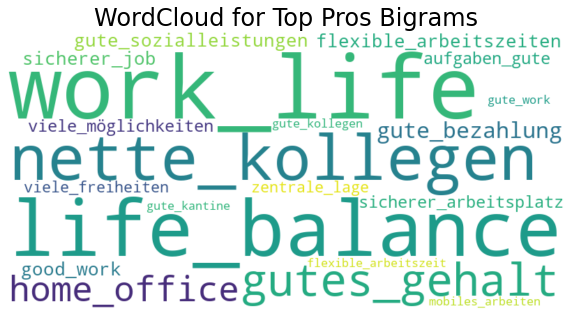

In [99]:
# Generate word clouds for top pros and cons bigrams
generate_wordcloud_from_bigrams(top_pros_bigrams, 'WordCloud for Top Pros Bigrams')

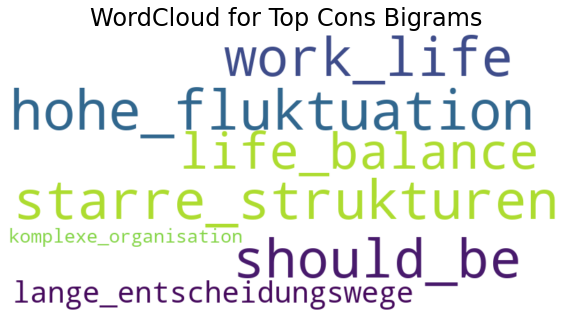

In [100]:
generate_wordcloud_from_bigrams(top_cons_bigrams, 'WordCloud for Top Cons Bigrams')

# Continue here

## Feature Engineering
- Sentiment Analysis
- Text Length
- Word Count

In [52]:
# Calculate sentiment polarity for 'pros' and 'cons' columns
df['pros_sentiment'] = df['pros'].apply(lambda text: TextBlobDE(text).sentiment.polarity)
df['cons_sentiment'] = df['cons'].apply(lambda text: TextBlobDE(text).sentiment.polarity)

# Calculate text length and word count for 'pros' and 'cons' columns
df['pros_length'] = df['pros'].apply(len)
df['cons_length'] = df['cons'].apply(len)
df['pros_word_count'] = df['pros'].apply(lambda text: len(text.split()))
df['cons_word_count'] = df['cons'].apply(lambda text: len(text.split()))


In [53]:
df.head()

,title,author_info,rating,pros,cons,date,job,text,review_length,pros_length,cons_length,pros_sentiment,cons_sentiment,pros_word_count,cons_word_count
0,Super,5. Mai 2023 - Chemikant und Anlagenfahrer,5,"Gutes Gehalt, gute Arbeitszeit, gute Kollegen,...",Ein riesiger laden etwas zu groß für mich,2023-05-05,Chemikant und Anlagenfahrer,"Super Gutes Gehalt, gute Arbeitszeit, gute Kol...",108,60,41,1.000000,0.700000,8,8
1,Verbesserungsvorschläge für eine noch bessere ...,20. Mai 2023 - Anlagenmechaniker,4,Globale Präsenz: BASF ist ein multinationaler ...,Größe und Komplexität: Als globaler Konzern mi...,2023-05-20,Anlagenmechaniker,Verbesserungsvorschläge für eine noch bessere ...,2742,1342,1328,0.007576,0.077778,162,169
2,"Gutes Gehalt, flexible Zeiten",23. Mai 2023 - Industriemechaniker,4,Das Einstiegsgehalt ist für einen Ausbildungsb...,Aufstiegsmöglichkeiten aufgrund der hohen Meng...,2023-05-23,Industriemechaniker,"Gutes Gehalt, flexible Zeiten Das Einstiegsgeh...",405,281,93,0.616667,-1.000000,38,12
3,"Nettes Team, gute Erfahrung",16. Mai 2023 - Werkstudent,3,"Team, Einblicke, Support... Es hat Spaß gemach...",Die Organisation hat zeitweilig zu wünschen üb...,2023-05-16,Werkstudent,"Nettes Team, gute Erfahrung Team, Einblicke, S...",176,88,59,0.500000,0.000000,14,8
4,Führen durch Intransparenz,5. Mai 2023 - Ingenieur,2,Kündigungsschutz (betrieblich bedingt) von 5 J...,"Management, Führungskräfte und das gesamte Sys...",2023-05-05,Ingenieur,Führen durch Intransparenz Kündigungsschutz (b...,277,51,198,-0.700000,0.350000,6,25


Lets calculate average len of each rating, len of positive text and len of negative text

## Sentiment Analysis

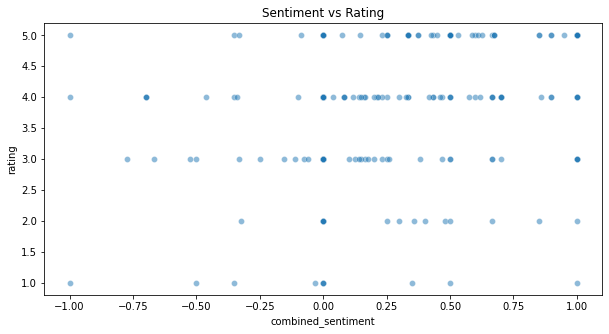

In [55]:
# Calculate sentiment polarity for the combined text
df['combined_sentiment'] = df['text'].apply(lambda text: TextBlobDE(text).sentiment.polarity)

# Compare sentiment with rating
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='combined_sentiment', y='rating', alpha=0.5)
plt.title('Sentiment vs Rating')
plt.show()

In [56]:
df[['rating', 'combined_sentiment']]

,rating,combined_sentiment
0,5,0.850000
1,4,0.039167
2,4,0.212500
3,3,0.666667
4,2,0.000000
...,...,...
182,4,0.000000
183,1,-0.350000
184,4,0.216667
185,3,0.500000


In [57]:
# Calculate correlation
correlation = df[['rating', 'combined_sentiment']].corr().iloc[0, 1]
print('Correlation between sentiment and rating:', correlation)

Correlation between sentiment and rating: 0.2521319719831062


## Job Clustering and Job Sentiment

In [58]:
df.job.value_counts()

Anonymer Mitarbeiter                              18
Werkstudent                                       11
Chemikant                                          6
Ingenieur                                          5
Praktikant                                         4
                                                  ..
Volontär/in                                        1
Patentrechercheur                                  1
Werkstudentin Interne und Online Kommunikation     1
Key Account Manager                                1
Assistent der Geschäftsleitung                     1
Name: job, Length: 126, dtype: int64

In [101]:
# Define job categories
job_categories = {
    'HR': ['HR', 'Recruiter'],
    'Werkstudent:in': ['Werkstudent'],
    'Mechaniker:in': ['Mechaniker'],
    'Manager:in': ['Manager'],
    'Praktikant:in': ['Praktikant', 'Internship', 'Praktikum'],
    'Ingenieur:in': ['Ingenieur', 'Engineer'],
    'Chemikant:in': ['Chemikant', 'Chemiker'],
    'Data Scientist': ['Data Scientist', 'Analyst'],
    'Assistent:in': ['Assistent', 'Assistant'],
    'Student:in': ['Bachelor', 'Master'],
    'Anonyme Mitarbeiter': ['Anonym'],
    'Finance': ['Controller', 'Controlling', 'Accountant', 'Finanz', 'Credit', 'Buchhalter', 'Finance'],
    'Laborant:in': ['Labor'],
    'Teamleiter:in': ['Team', 'Leiter'],
}

# Create a new column for job category
df['job_category'] = np.nan  # Initialize with NaN

# Assign each job to a category based on the keywords
for category, keywords in job_categories.items():
    for keyword in keywords:
        df.loc[df['job'].str.contains(keyword, case=False, na=False), 'job_category'] = category

# If a job doesn't fit into any of the defined categories, assign it to 'Other'
df['job_category'] = df['job_category'].fillna('Other')

In [60]:
pd.set_option('display.max_rows', None)
df[['job', 'job_category']]

,job,job_category
0,Chemikant und Anlagenfahrer,Chemikant
1,Anlagenmechaniker,Mechaniker
2,Industriemechaniker,Mechaniker
3,Werkstudent,Werkstudent
4,Ingenieur,Ingenieur
5,Finance Senior Specialist,Finance
6,Senior DevOps Engineer,Ingenieur
7,Werkstudent,Werkstudent
8,HR Generalist,HR
9,Laborteamleiter,Teamleiter


In [61]:
pd.set_option('display.max_rows', None)
df[['job', 'job_category']].loc[df['job_category']=="Other"]

,job,job_category
12,Kaufmännische Angestellte,Other
13,Director,Other
15,Digital Expert,Other
21,Product Stewardship,Other
23,Bereichsleitung,Other
24,Collection Officer,Other
25,Posdoctoral Researcher,Other
26,Senior Reporting Specialist,Other
27,Studentische Aushilfe,Other
34,SAP Security and GRC Consultant,Other


In [102]:
# Count the number of each job category
df['job_category'].value_counts()

Other                  50
Manager:in             21
Finance                19
Anonyme Mitarbeiter    18
Werkstudent:in         14
Ingenieur:in           14
Chemikant:in            9
HR                      9
Praktikant:in           9
Teamleiter:in           7
Student:in              5
Laborant:in             5
Data Scientist          3
Mechaniker:in           2
Assistent:in            2
Name: job_category, dtype: int64

In [63]:
# We see that we have a lot of writing mistakes.
from spellchecker import SpellChecker

# Initialize spell checkers for English and German
spell_en = SpellChecker(language='en')
spell_de = SpellChecker(language='de')

def correct_spelling(title):
    words = title.split()  # Split the title into words
    corrected_words = []

    # Initialize the counter
    corrections = 0

    for word in words:
        # Correct spelling using the English spell checker
        corrected_word_en = spell_en.correction(word)
    
        # Correct spelling using the German spell checker
        corrected_word_de = spell_de.correction(word)
    
        # If the German correction is the same as the original word, use the English correction
        # Otherwise, use the German correction
        if corrected_word_de == word:
            final_word = corrected_word_en
        else:
            final_word = corrected_word_de

        # If the final word is 'None', keep the original word
        if final_word is None:
            final_word = word

        corrected_words.append(final_word)
        
        # If the final word is different from the original word, print the correction and increment the counter
        if final_word != word:
            print(f"Corrected '{word}' to '{final_word}'")
            corrections += 1

    # Join the corrected words back into a title
    corrected_title = ' '.join(corrected_words)

    return corrected_title, corrections

# Use this function to correct your job titles and count corrections
corrected_job_titles = []
total_corrections = 0

for title in df['Job']:
    corrected_title, corrections = correct_spelling(title)
    corrected_job_titles.append(corrected_title)
    total_corrections += corrections

print(f"Total corrections made: {total_corrections}")

KeyError: 'Job'

# OLD CODE

## Data Preprocessing / Data Cleaning
To be able to make text processable for machines, we have to perform some preprocessing steps. This includes lowercasing, removing punctuations, removing stopwords, stemming or lemmatization and removing any additional noise in the data. For this tasks we can use the NLTK (Natural Language Toolkit) and Spacy library, which provide us with already implemented useful functionalities.

One could also use TextBlob library which supports multiple languages, including German, but for our task we chose SpaCy for the following reasons:
- Better language support: SpaCy has dedicated support for German language, including word vectors, part-of-speech tagging, named entity recognition, and syntactic parsing. This is beneficial if our plan to extend your analysis to more advanced NLP tasks.
- Efficiency: SpaCy is generally faster and more efficient than TextBlob, especially for larger datasets. Even though our dataset is small at the beginning
- Customization: SpaCy allows more flexibility and customization. One can integrate it with other libraries and it supports custom pipelines and extensions.

There are also pre-trained models available for German such as "oliverguhr/german-sentiment-bert" from Hugging Face's model hub which can be integrated with SpaCy.

In [64]:
# Downloading the stop words and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Loading the German NLP pipeline in SpaCy
nlp = spacy.load('de_core_news_sm')

# Define the stopwords list
stop_words = set(stopwords.words('german'))
stop_words.add('basf') # Add company name to stop words as it does not provide any sentiment information

def preprocess_text(text):
    """
    Function to build tokenized texts from input text
    """
    # Tokenize the sentence
    tokenized = sent_tokenize(text)
    
    for i in range(len(tokenized)):
        # Tokenize the words
        words = nltk.word_tokenize(tokenized[i])
        
        # Removing punctuation, converting to lower case and removing stopwords
        words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
        
        # Lemmatization
        doc = nlp(' '.join(words))
        words = [token.lemma_ for token in doc]
        
        tokenized[i] = ' '.join(words)
    
    return tokenized

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [65]:
# Apply preprocessing to each review
df['pros'] = df['pros'].apply(preprocess_text)
df['cons'] = df['cons'].apply(preprocess_text)
df['title'] = df['title'].apply(preprocess_text)

In [66]:
# Join 'title', 'pros', and 'cons' for each review
df['all_text'] = df['title'].str.join(' ') + ' ' + df['pros'].str.join(' ') + ' ' + df['cons'].str.join(' ')

In [67]:
# Prepare the labels
def to_label(rating):
    if rating >= 4:
        return 1
    elif rating == 3:
        return 0
    else:
        return -1

df['label'] = df['rating'].apply(to_label)

## Sentiment Analysis
We will use a pre-trained sentiment analysis model that supports German. We can either choose the popular BERT model which has a version pre-trained on German text ("bert-base-german-cased"), which however requires some finetuning or use the TextBlob library which also supports German and is quite simple to use.

In [68]:
def get_sentiment(text):
    # Join the list of words into a single string
    text = ' '.join(text)
    # Create TextBlob object of passed text 
    analysis = TextBlobDE(text) 
    # Return sentiment polarity 
    return analysis.sentiment.polarity 

# Apply sentiment analysis to each review
df['pros_sentiment'] = df['pros'].apply(get_sentiment)
df['cons_sentiment'] = df['cons'].apply(get_sentiment)
df['title_sentiment'] = df['title'].apply(get_sentiment)

In [69]:
df.head()

,title,author_info,rating,pros,cons,date,job,text,review_length,pros_length,cons_length,pros_sentiment,cons_sentiment,pros_word_count,cons_word_count,combined_sentiment,job_category,all_text,label,title_sentiment
0,[Super],5. Mai 2023 - Chemikant und Anlagenfahrer,5,[gut Gehalt gut Arbeitszeit gut Kollege Lecker...,[ein Riesiger laden groß],2023-05-05,Chemikant und Anlagenfahrer,"Super Gutes Gehalt, gute Arbeitszeit, gute Kol...",108,60,41,1.00,0.700,8,8,0.850000,Chemikant,Super gut Gehalt gut Arbeitszeit gut Kollege L...,1,1.0
1,[verbesserungsvorschläge gut Arbeitsumgebung B...,20. Mai 2023 - Anlagenmechaniker,4,[global Präsenz Basf multinational Chemiekonze...,[Größe Komplexität als global Konzern Vielzahl...,2023-05-20,Anlagenmechaniker,Verbesserungsvorschläge für eine noch bessere ...,2742,1342,1328,0.18,0.525,162,169,0.039167,Mechaniker,verbesserungsvorschläge gut Arbeitsumgebung Ba...,1,1.0
2,[gut Gehalt flexibel Zeit],23. Mai 2023 - Industriemechaniker,4,[der Einstiegsgehalt Ausbildungsberuf wirklich...,[Aufstiegsmöglichkeit aufgrund hoch Menge Leut...,2023-05-23,Industriemechaniker,"Gutes Gehalt, flexible Zeiten Das Einstiegsgeh...",405,281,93,0.90,0.700,38,12,0.212500,Mechaniker,gut Gehalt flexibel Zeit der Einstiegsgehalt A...,1,1.0
3,[nett Team gut Erfahrung],16. Mai 2023 - Werkstudent,3,[Team einblicken support es Spaß machen einbli...,[der Organisation zeitweilig wünschen übrig la...,2023-05-16,Werkstudent,"Nettes Team, gute Erfahrung Team, Einblicke, S...",176,88,59,1.00,0.000,14,8,0.666667,Werkstudent,nett Team gut Erfahrung Team einblicken suppor...,0,1.0
4,[führen Intransparenz],5. Mai 2023 - Ingenieur,2,[Kündigungsschutz betrieblich bedingt Jahr],[Management führungskräfte gesamt System funkt...,2023-05-05,Ingenieur,Führen durch Intransparenz Kündigungsschutz (b...,277,51,198,-0.70,0.700,6,25,0.000000,Ingenieur,führen Intransparenz Kündigungsschutz betriebl...,-1,0.0


The sentiment polarity returned by TextBlob ranges from -1 to 1, with -1 being negative, 0 neutral, and 1 positive

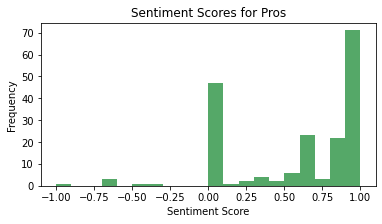

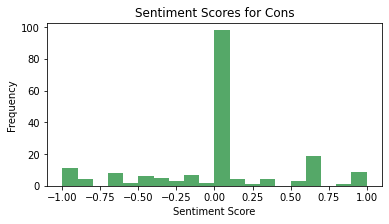

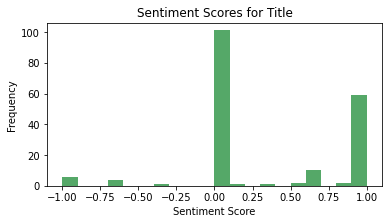

In [70]:
# Function to create histogram
def plot_sentiment(df, column, title):
    plt.figure(figsize=(6, 3))
    plt.hist(df[column], bins=20, color='#55a868')
    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

# Plot sentiment scores for pros, cons, and title
plot_sentiment(df, 'pros_sentiment', 'Sentiment Scores for Pros')
plot_sentiment(df, 'cons_sentiment', 'Sentiment Scores for Cons')
plot_sentiment(df, 'title_sentiment', 'Sentiment Scores for Title')

Now let's also calculate the sentiment using german BERT

In [71]:
model_name = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [72]:
# Define the sentiment calculation function
def get_sentiment_bert(text):
    
    inputs = tokenizer.encode_plus(text, return_tensors='pt', truncation=True, max_length=512)
    
    output = model(**inputs)
    
    sentiment_values, sentiment_indices = torch.max(output.logits, dim=1)
    
    # Negative: 0, Neutral: 1, Positive: 2
    return sentiment_indices.item() - 1

In [73]:
df['overall_sentiment'] = df['all_text'].apply(get_sentiment_bert)

In [74]:
df.head()

,title,author_info,rating,pros,cons,date,job,text,review_length,pros_length,...,pros_sentiment,cons_sentiment,pros_word_count,cons_word_count,combined_sentiment,job_category,all_text,label,title_sentiment,overall_sentiment
0,[Super],5. Mai 2023 - Chemikant und Anlagenfahrer,5,[gut Gehalt gut Arbeitszeit gut Kollege Lecker...,[ein Riesiger laden groß],2023-05-05,Chemikant und Anlagenfahrer,"Super Gutes Gehalt, gute Arbeitszeit, gute Kol...",108,60,...,1.00,0.700,8,8,0.850000,Chemikant,Super gut Gehalt gut Arbeitszeit gut Kollege L...,1,1.0,-1
1,[verbesserungsvorschläge gut Arbeitsumgebung B...,20. Mai 2023 - Anlagenmechaniker,4,[global Präsenz Basf multinational Chemiekonze...,[Größe Komplexität als global Konzern Vielzahl...,2023-05-20,Anlagenmechaniker,Verbesserungsvorschläge für eine noch bessere ...,2742,1342,...,0.18,0.525,162,169,0.039167,Mechaniker,verbesserungsvorschläge gut Arbeitsumgebung Ba...,1,1.0,1
2,[gut Gehalt flexibel Zeit],23. Mai 2023 - Industriemechaniker,4,[der Einstiegsgehalt Ausbildungsberuf wirklich...,[Aufstiegsmöglichkeit aufgrund hoch Menge Leut...,2023-05-23,Industriemechaniker,"Gutes Gehalt, flexible Zeiten Das Einstiegsgeh...",405,281,...,0.90,0.700,38,12,0.212500,Mechaniker,gut Gehalt flexibel Zeit der Einstiegsgehalt A...,1,1.0,-1
3,[nett Team gut Erfahrung],16. Mai 2023 - Werkstudent,3,[Team einblicken support es Spaß machen einbli...,[der Organisation zeitweilig wünschen übrig la...,2023-05-16,Werkstudent,"Nettes Team, gute Erfahrung Team, Einblicke, S...",176,88,...,1.00,0.000,14,8,0.666667,Werkstudent,nett Team gut Erfahrung Team einblicken suppor...,0,1.0,-1
4,[führen Intransparenz],5. Mai 2023 - Ingenieur,2,[Kündigungsschutz betrieblich bedingt Jahr],[Management führungskräfte gesamt System funkt...,2023-05-05,Ingenieur,Führen durch Intransparenz Kündigungsschutz (b...,277,51,...,-0.70,0.700,6,25,0.000000,Ingenieur,führen Intransparenz Kündigungsschutz betriebl...,-1,0.0,1


## Use a Pre-Trained Model and Fine-Tune it

In [ ]:
# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['all_text'], df['label'], test_size=0.2)

# Load a pre-trained tokenizer
model_name = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

# Convert to PyTorch datasets
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels.tolist())
val_dataset = ReviewDataset(val_encodings, val_labels.tolist())

# Load a pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Set up the Trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Fine-tune the model
trainer.train()

## Keyword Extraction
Now we will perform a keyword extraction to identify most common words associated with positive and negative sentiments. This can help identify key themes or topcis in the feedback.

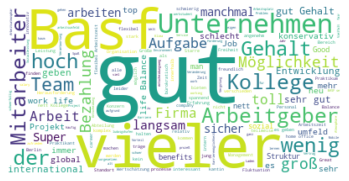

In [75]:
# Separate positive and negative reviews
positive_reviews = df[df['rating'] >= 3]['all_text'] # if rating >= 3, the review is positive
negative_reviews = df[df['rating'] < 3]['all_text'] # if rating < 3, the review is negative
# TODO: Maybe also check if the calculated sentiment is fitting to the star rating of the reveiw

# Concatenate all positive reviews and all negative reviews
raw_text_positive = ' '.join(positive_reviews)
raw_text_negative = ' '.join(negative_reviews)

# Generate word cloud for positive reviews
wc_positive = WordCloud(background_color='white')
wc_positive.generate(raw_text_positive)

# Display the word cloud
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

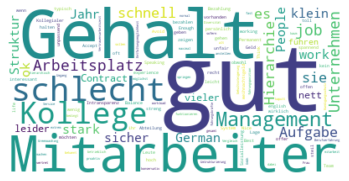

In [76]:
# Generate word cloud for negative reviews
wc_negative = WordCloud(background_color='white')
wc_negative.generate(raw_text_negative)

# Display the word cloud
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that negative reviews still contain positive words which is due to the fact that we also considered the 'pros' in the negative reviews. We will adjust for this by only taking the 'pros' of positive reviews and the 'cons' of negative reviews into account.

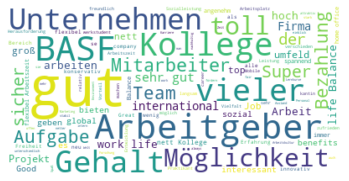

In [77]:
# Join 'title' and 'pros' for each positive review
df['positive_text'] = df.loc[df['rating'] >= 3, 'title'].str.join(' ') + ' ' + df.loc[df['rating'] >= 3, 'pros'].str.join(' ')

# Join 'title' and 'cons' for each negative review
df['negative_text'] = df.loc[df['rating'] < 3, 'title'].str.join(' ') + ' ' + df.loc[df['rating'] < 3, 'cons'].str.join(' ')

# Concatenate all positive and negative texts
raw_text_positive = ' '.join(df['positive_text'].dropna())
raw_text_negative = ' '.join(df['negative_text'].dropna())

# Generate word cloud for positive text
wc_positive = WordCloud(background_color='white')
wc_positive.generate(raw_text_positive)

# Display the word cloud
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

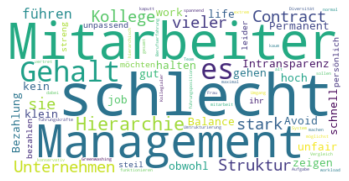

In [78]:
# Generate word cloud for negative text
wc_negative = WordCloud(background_color='white')
wc_negative.generate(raw_text_negative)

# Display the word cloud
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

## Actionable Insights

In [103]:
avg_ratings_by_job = df.groupby('job_category')['rating'].mean().sort_values(ascending=False)
print(avg_ratings_by_job)

job_category
Data Scientist         4.666667
Teamleiter:in          4.571429
Chemikant:in           4.333333
Manager:in             4.095238
Ingenieur:in           4.000000
Laborant:in            4.000000
Mechaniker:in          4.000000
Praktikant:in          4.000000
Werkstudent:in         3.928571
Other                  3.740000
Student:in             3.600000
Assistent:in           3.500000
Anonyme Mitarbeiter    3.388889
HR                     3.222222
Finance                2.947368
Name: rating, dtype: float64


In [112]:
# Replace "Anonyme Mitarbeiter" with "Anon. Mitarbeiter"
avg_ratings_by_job.index = avg_ratings_by_job.index.to_series().replace('Anon. Mitarbeiter', 'Anon. MA')

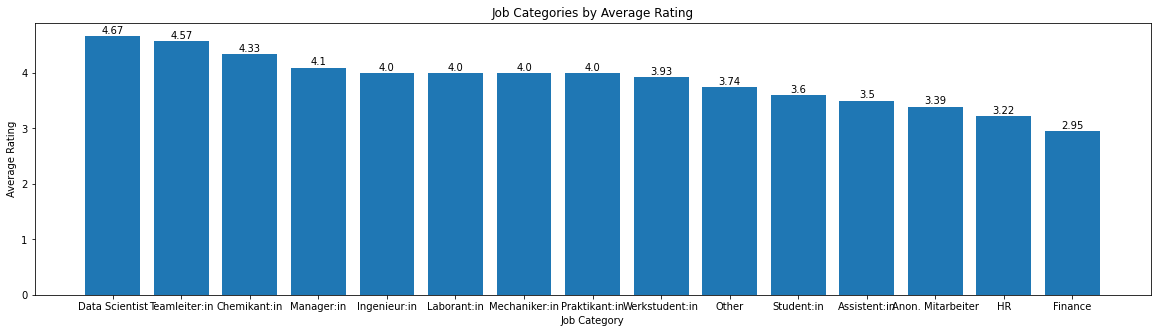

In [105]:
# Create a bar plot
plt.figure(figsize=(20,5)) # Specify the figure size
bars = plt.bar(avg_ratings_by_job.index, avg_ratings_by_job.values, color=sns.color_palette()[0]) # Plot the bar chart

# Label the axes and the chart
plt.xlabel('Job Category')
plt.ylabel('Average Rating')
plt.title('Job Categories by Average Rating')

# Add the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Show the plot
#plt.xticks(rotation=45, ha='right')
plt.show()

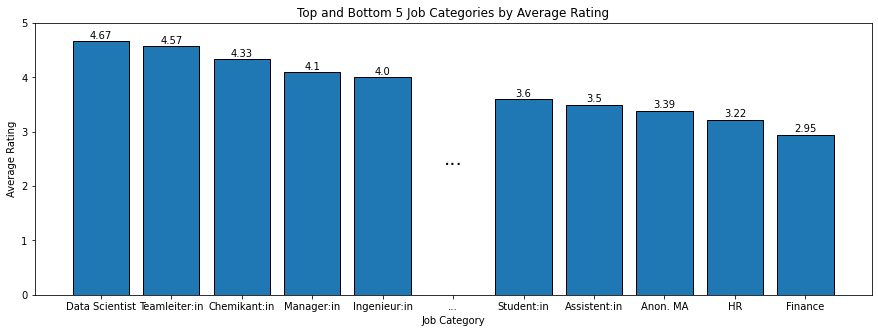

In [117]:
# Select top 5 and bottom 5 job categories
top_5_job_categories = avg_ratings_by_job[:5]
bottom_5_job_categories = avg_ratings_by_job[-5:]

# Combine top 5, '...', and bottom 5 job categories
combined_ratings = pd.concat([top_5_job_categories, 
                              pd.Series([np.nan], index=['...']), 
                              bottom_5_job_categories])

# Create a bar plot
plt.figure(figsize=(15,5)) # Increase figure size for better spacing
bars = plt.bar(combined_ratings.index, combined_ratings.values, color=sns.color_palette()[0], edgecolor='black')

# Add '...' text annotation at y=2.5
plt.text(len(top_5_job_categories), 2.5, '...', ha='center', va='center', fontsize=20)

# Label the axes and the chart
plt.xlabel('Job Category')
plt.ylabel('Average Rating')
plt.title('Top and Bottom 5 Job Categories by Average Rating')

# Set y-axis limits
plt.ylim([0, 5])

# Add the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    if pd.notnull(yval):
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.savefig('plots/top_and_bottom_jobs.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

In [80]:
# Calculate the number of reviews for each job title
review_counts = df['job'].value_counts()
review_counts

Anonymer Mitarbeiter                              18
Werkstudent                                       11
Chemikant                                          6
Ingenieur                                          5
Praktikant                                         4
Accountant                                         4
Recruiter                                          3
Manager/In                                         3
Junior Controller                                  3
Director                                           3
Wirtschaftsingenieur                               2
Chemikant und Anlagenfahrer                        2
                                                   2
Projektmanager/in                                  2
Data Scientist                                     2
Project Manager                                    2
Research Scientist                                 2
Chemielaborant                                     2
Laborleiter                                   

In [81]:
# Find job titles with more than 50 reviews
common_jobs = review_counts[review_counts > 50].index

# Calculate average ratings for these job titles
avg_ratings_by_job = df[df['job'].isin(common_jobs)].groupby('job')['rating'].mean().sort_values(ascending=False)
print(avg_ratings_by_job)

Series([], Name: rating, dtype: float64)


IndexError: index 0 is out of bounds for axis 0 with size 0

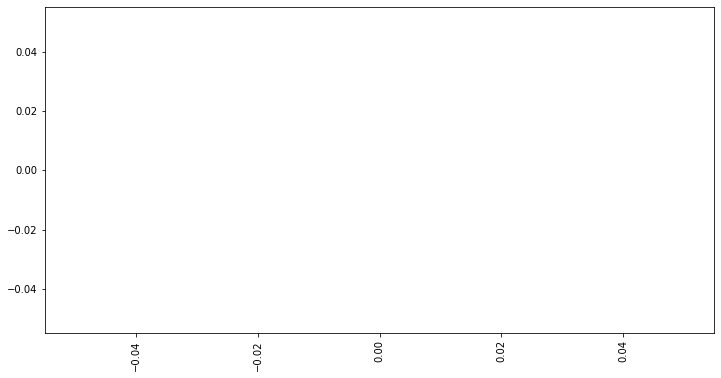

In [82]:
avg_ratings_by_job.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Job Title')
plt.ylabel('Average Rating')
plt.title('Average Rating by Job Title')
plt.show()

### Next Todos:
- gibt es einen Zusammenhang zwischen der Position (Mechaniker, Werkstudent etc.) und dem Sentiment und der Bewertung?
- use BERT model for comparison
- perform topic modeling using LDA
- using keyword extraction algorithms like TF-IDF or RAKE
- CHAT-GPT ganzen Code geben, soll dazu eine Doku schreiben / an jede sinnvollen Stelle im Notebook

In [ ]:
# Use Text blob?

In [ ]:
def analyze_sentiment(text):

    testimonial = TextBlob(text)
    return testimonial.sentiment

In [ ]:
df['pros_sentiment'] = df['pros'].apply(analyze_sentiment)

df['cons_sentiment'] = df['cons'].apply(analyze_sentiment)

In [ ]:
df.head()

In [ ]:
avg_pros_polarity = df['pros_sentiment'].apply(lambda x: x.polarity).mean()
avg_cons_polarity = df['cons_sentiment'].apply(lambda x: x.polarity).mean()

print('Average polarity of pros:', avg_pros_polarity)
print('Average polarity of cons:', avg_cons_polarity)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(2)

# Plot histogram of pros sentiment
pros_polarity = df['pros_sentiment'].apply(lambda x: x.polarity)
axs[0].hist(pros_polarity, bins=20, color='g')
axs[0].set_title('Pros Sentiment Polarity')

# Plot histogram of cons sentiment
cons_polarity = df['cons_sentiment'].apply(lambda x: x.polarity)
axs[1].hist(cons_polarity, bins=20, color='r')
axs[1].set_title('Cons Sentiment Polarity')

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Set up stop words
stop_words = set(stopwords.words('german'))

# Tokenize the text
df['pros_tokens'] = df['pros'].apply(nltk.word_tokenize)
df['cons_tokens'] = df['cons'].apply(nltk.word_tokenize)

# Remove stop words
df['pros_tokens'] = df['pros_tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['cons_tokens'] = df['cons_tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['pros_tokens'])

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in df['pros_tokens']]

# Train LDA model.
lda = models.LdaModel(corpus, num_topics=2, id2word=dictionary)

# Print the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)